## Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import linregress

from datetime import datetime
import random
import os
import seaborn as sns
import importlib

from PIL import Image
from sklearn.cluster import KMeans

In [2]:
from skimage.segmentation import slic
from skimage.color import rgb2lab, lab2rgb
from skimage.util import img_as_ubyte
from skimage.measure import regionprops

## Start

In [66]:
import src.ArT_functions; import src.comic_book; import src.general_functions
importlib.reload(src.ArT_functions); importlib.reload(src.comic_book); importlib.reload(src.general_functions);
from src.ArT_functions import *; from src.comic_book import *; from src.general_functions import *

In [67]:
input_image_path = 'input/1705_JesseMetz1439.jpg'
output_image_path = 'output/output_image.jpg'
input_image = extract_square(input_image_path, target_size=1000)

## Move boxes

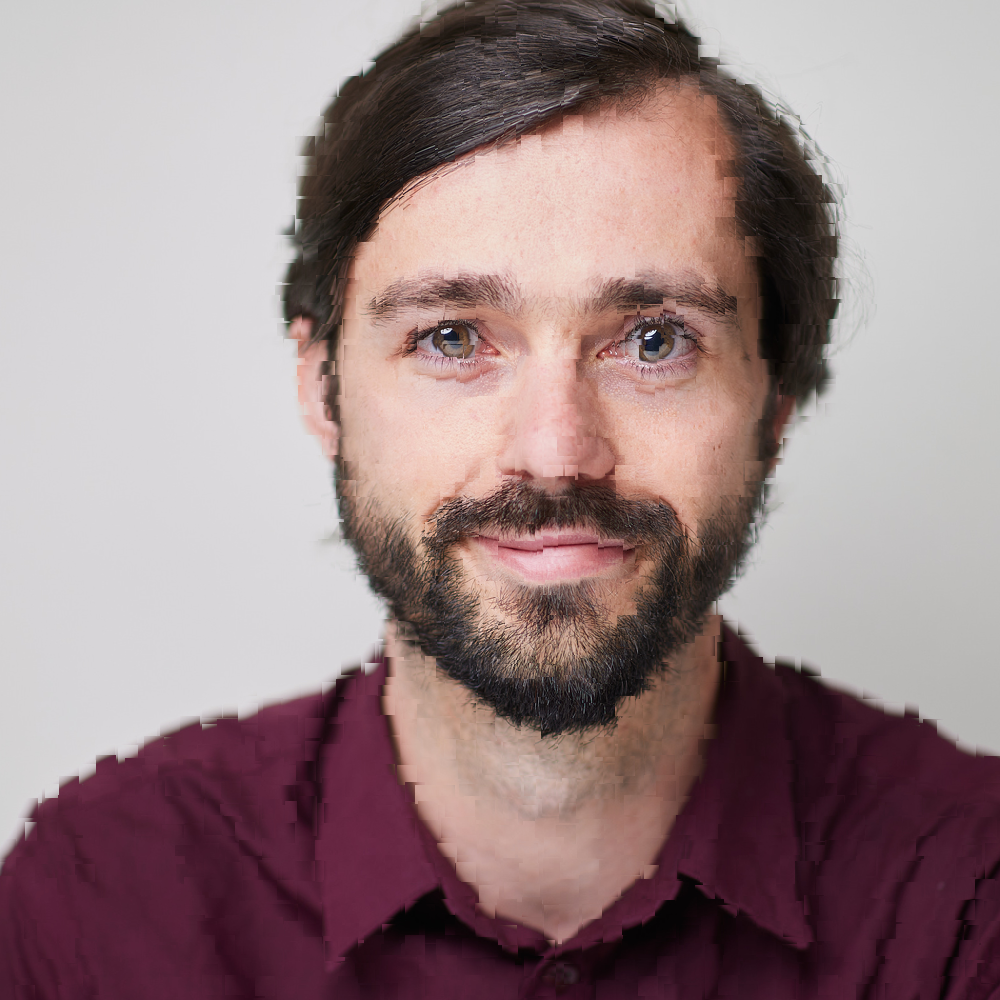

In [65]:
np.random.seed(46)
altered_image = alter_image_init(input_image)
# altered_image = alter_image_boxes_away_from_center(input_image, num_rectangles=1000)
# altered_image = alter_image_boxes(input_image, num_rectangles=10000, magnitude=.1)
save_image_with_unique_name(altered_image, output_image_path)
altered_image

## Segments

In [6]:
def segment_image_with_background(img, number_of_regions, background_color=(255, 255, 255), region_size_factor=5):
    img_array = np.array(img)

    # Convert image to LAB color space for better segmentation
    img_lab = rgb2lab(img_array)

    # Calculate the maximum size per region based on the image width
    max_region_size = img.width // region_size_factor

    # Perform SLIC segmentation
    segments = slic(
        img_lab,
        n_segments=number_of_regions,
        compactness=10, 
        max_size_factor=max_region_size,
        start_label=1,
    )

    # Identify the largest region as the background
    regions = regionprops(segments)
    largest_region = max(regions, key=lambda r: r.area)
    
    # Create a new image and fill with random colors and background color
    segmented_img = np.zeros_like(img_array)
    for region in regions:
        coords = region.coords
        if region.label == largest_region.label:
            segmented_img[coords[:, 0], coords[:, 1]] = background_color  # Set background color
        else:
            random_color = np.random.randint(0, 256, size=3)  # Assign random colors to other regions
            segmented_img[coords[:, 0], coords[:, 1]] = random_color

    # Convert back to PIL image
    segmented_img_pil = Image.fromarray(img_as_ubyte(segmented_img))
    return segmented_img_pil

In [7]:
background_img = segment_image_with_background(input_image, number_of_regions=100, background_color=(255, 255, 255))
# save_image_with_unique_name(background_img, output_image_path)
# background_img

In [8]:
def segment_image_with_spatial_constraints(img, number_of_regions, region_size_factor=5, color_style="colors"):
    img_array = np.array(img)

    # Convert image to LAB color space for better color segmentation
    img_lab = rgb2lab(img_array)

    # Calculate the maximum size per region based on the image width
    max_region_size = img.width // region_size_factor
    
    # Perform SLIC segmentation
    segments = slic(
        img_lab,
        n_segments=number_of_regions,
        compactness=10,  # Balances color similarity and spatial proximity; adjust if needed
        max_size_factor=max_region_size,
        start_label=1,
    )

    # Replace each segment with a random color
    if color_style == "colors":  # Random colors
        segmented_img = np.zeros_like(img_array)
        for region in regionprops(segments):
            coords = region.coords
            random_color = np.random.randint(0, 256, size=3)  # Generate a random RGB color
            segmented_img[coords[:, 0], coords[:, 1]] = random_color
    else:  # 
        segmented_img = np.zeros_like(img_array)
        for region in regionprops(segments):
            # Get pixel indices for each region
            coords = region.coords
            # Average the color of each region
            average_color = np.mean(img_array[coords[:, 0], coords[:, 1]], axis=0)
            # Fill the region with the average color
            segmented_img[coords[:, 0], coords[:, 1]] = average_color

    # Convert back to PIL image
    segmented_img_pil = Image.fromarray(img_as_ubyte(segmented_img))
    return segmented_img_pil

In [9]:
segmented_img = segment_image_with_spatial_constraints(input_image, number_of_regions=3, color_style="colors")

# save_image_with_unique_name(segmented_img, output_image_path)
# segmented_img

In [10]:
def segment_and_average(img, number_of_regions):
    img_array = np.array(img)
    
    # Reshape the array into (number of pixels, 3) for RGB
    pixels = img_array.reshape(-1, 3)
    
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=number_of_regions, random_state=42)
    kmeans.fit(pixels)
    
    # Get cluster centers (average colors) and labels (which cluster each pixel belongs to)
    average_colors = kmeans.cluster_centers_.astype(int)
    labels = kmeans.labels_
    
    # Replace pixel colors with the average color of their cluster
    segmented_pixels = average_colors[labels]
    
    # Reshape the array back to the original image shape
    segmented_img_array = segmented_pixels.reshape(img_array.shape)
    
    # Convert back to PIL Image
    segmented_img = Image.fromarray(segmented_img_array.astype('uint8'))
    return segmented_img

In [11]:
segmented_img = segment_and_average(input_image, number_of_regions=3)
# save_image_with_unique_name(segmented_img, output_image_path)
# segmented_img